In [1]:
# Automatic reloading of imports
%load_ext autoreload
%autoreload 2

import os
import sys
from astropy.io import fits
from astropy.time import Time
from astropy.constants import c
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import ndimage
from scipy.interpolate import splrep, splev
# Put in the pyodine path on your machine here!
pyodine_path = '/Users/samkleiman/pyodine/'

sys.path.append(pyodine_path)

import pyodine
import utilities_song

In [2]:
# The atlas pathname
ref_pathname = os.path.join(pyodine_path, 'pyodine/reference/arcturus/ardata.fits')

# 'arcturus' for Arcturus, 'solarflux' for the Sun
ref_star = 'arcturus'

with fits.open(ref_pathname) as h:
    # Get wavelength
    ref_wave = h[1].data['wavelength']
    # Get flux
    ref_flux = h[1].data[ref_star]

# Clip it down to the part relevant for us
wave_limits = (4970., 6250.)

ind = np.where(np.logical_and(ref_wave>wave_limits[0], ref_wave<wave_limits[1]))
ref_wave = ref_wave[ind[0]]
ref_flux = ref_flux[ind[0]]

Nr. of identified tellurics:  33


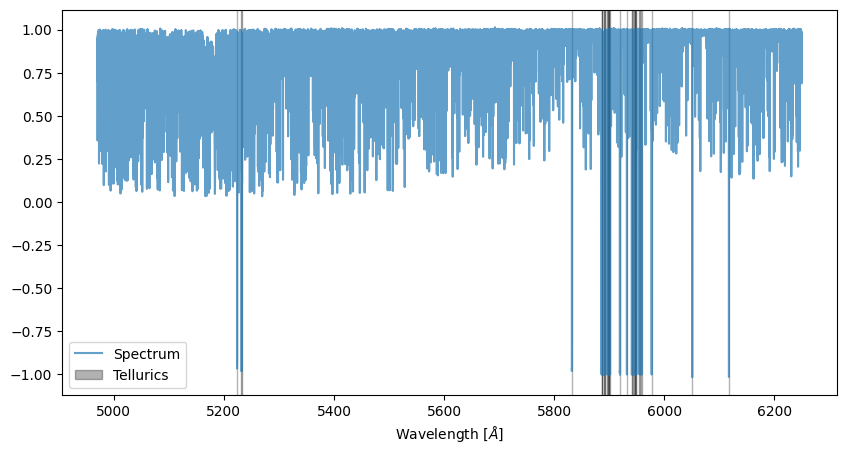

In [3]:
# Function to identify the telluric lines in the atlas
def identify_objects(image, threshold):
    """Modified from the internet: Returns a mask of numbers, 
    with the lowest value being the background (0), then 1 and 2 etc...
    
    http://stackoverflow.com/questions/5298884/finding-number-of-colored-shapes-from-picture-using-python
    """
    # Find connected components
    labeled, nr_objects = ndimage.label(image < threshold)
     
    return labeled, nr_objects

# Here we go: tellurics are around -1 in the spectrum (so below threshold of -0.5)
tell_mask, nr_tellurics = identify_objects(ref_flux, -0.5)
print("Nr. of identified tellurics: ", nr_tellurics)

# Plot spectrum and shade identified tellurics to check
fig = plt.figure(figsize=(10,5))
plt.plot(ref_wave, ref_flux, alpha=0.7)
for i in range(nr_tellurics):
    plt.axvspan(ref_wave[np.where(tell_mask==i+1)[0][0]], 
                ref_wave[np.where(tell_mask==i+1)[0][-1]], 
                color='k', alpha=0.3)
plt.legend(['Spectrum', 'Tellurics'])
plt.xlabel(r'Wavelength [$\AA$]')
#plt.xlim(5220, 5240)
plt.show()

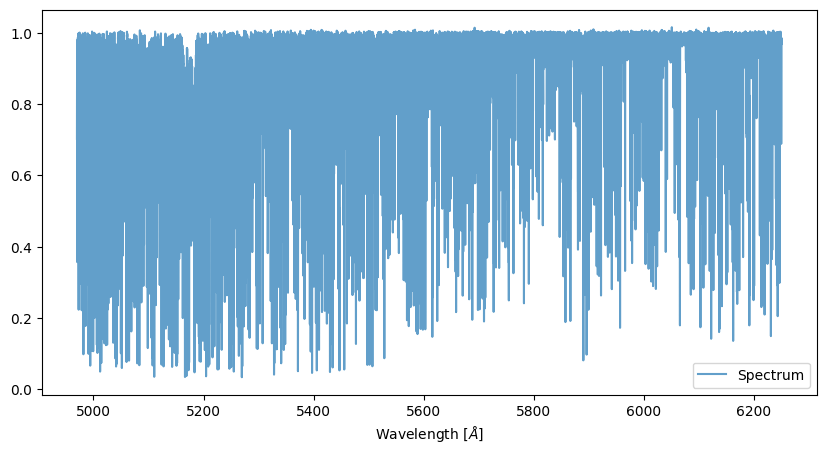

In [4]:
# Now loop through the telluric features and "fix" them (through interpolation)
ref_flux2 = ref_flux.copy()
for i in range(nr_tellurics):
    ind = np.where(tell_mask==i+1)
    tell_wave = ref_wave[ind]
    tell_flux = ref_flux[ind]
    # If any flux value is unequal to one, try to just "mirror up"
    if any(tell_flux != -1.):
        ref_flux2[ind] = tell_flux * -1
    # Otherwise try to interpolate between the left and right edge
    else:
        # Linear, not so fancy (but might just be enough, as it gets down-sampled anyway)
        #ref_flux2[ind] = np.linspace(ref_flux[ind[0][0]-1], ref_flux[ind[0][-1]+1], len(ind[0])+2)[1:-1]
        
        # Or try a smoother interpolation between left and right edge (this works nicely)
        ind_left = np.arange(ind[0][0]-20, ind[0][0])
        ind_right = np.arange(ind[0][-1]+1, ind[0][-1]+21)
        ext_wave = ref_wave[np.concatenate((ind_left, ind_right), axis=0)]
        ext_flux = ref_flux[np.concatenate((ind_left, ind_right), axis=0)]
        
        tck = splrep(ext_wave, ext_flux, s=0)
        int_flux = splev(tell_wave, tck, der=0)
        ref_flux2[ind] = int_flux


# Again plot to check
fig = plt.figure(figsize=(10,5))
plt.plot(ref_wave, ref_flux2, alpha=0.7)
plt.legend(['Spectrum'])
plt.xlabel(r'Wavelength [$\AA$]')
#plt.xlim(5220, 5240)
plt.show()

In [5]:
# Load a Sigma Draconis observation
obs_filepath = os.path.join(pyodine_path, 
    'tutorial_data/sigdra_obs_tutorial/s1_2015-05-02T03-48-48_ext.fits')
obs = utilities_song.load_pyodine.ObservationWrapper(obs_filepath)

# Load normalizer (to find reference velocity of observation and template)
nmz = pyodine.template.normalize.SimpleNormalizer(reference='arcturus')
# Order range 4 to 17 should be redward of the I2 region
obs_velocity = nmz.guess_velocity(obs[4:17])
arc_velocity = nmz.guess_velocity(pyodine.components.Spectrum(ref_flux2, ref_wave))
print('Observation velocity: {:.2f} m/s'.format(obs_velocity))
print('Arcturus spec velocity: {:.2f} m/s'.format(arc_velocity))

Observation velocity: 26631.51 m/s
Arcturus spec velocity: 12.70 m/s


In [6]:
# First and last order of observation to use
# (these are from the Template_Parameters for SONG)
first_order = 18
last_order  = 41
# Order correction for this observation
order_correction = -1

print('First order ({}) wavelength limits: {:.2f}-{:.2f}'.format(
    first_order+order_correction, 
    obs[first_order+order_correction].wave[0], 
    obs[first_order+order_correction].wave[-1]))
print('Last order ({}) wavelength limits: {:.2f}-{:.2f}'.format(
    last_order+order_correction, 
    obs[last_order+order_correction].wave[0], 
    obs[last_order+order_correction].wave[-1]))

First order (17) wavelength limits: 4994.14-5037.88
Last order (40) wavelength limits: 6154.39-6208.05


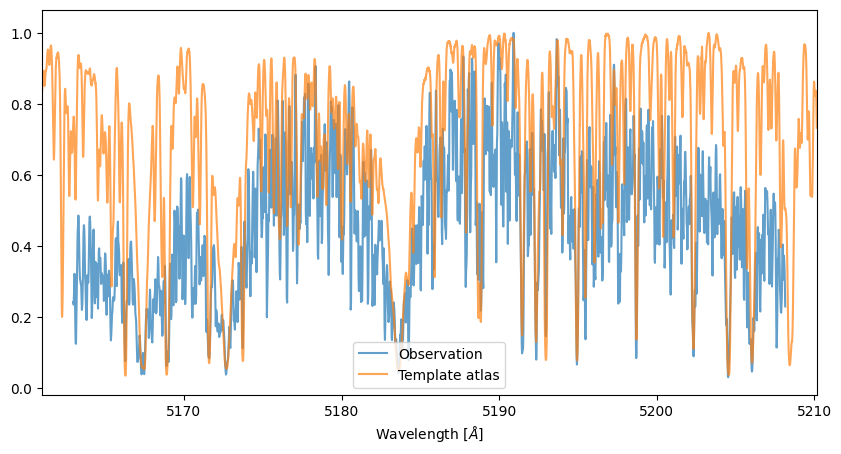

In [7]:
# Calculate Doppler shift of observation
z_obs = obs_velocity / c.value

# Plot this order
plot_order = 21

fig = plt.figure(figsize=(10,5))
plt.plot(obs[plot_order].wave * (1-z_obs), 
         obs[plot_order].flux/np.max(obs[plot_order].flux), alpha=0.7)
plt.plot(ref_wave, ref_flux2, alpha=0.7)
plt.xlim((obs[plot_order].wave * (1-z_obs))[0]-2, (obs[plot_order].wave * (1-z_obs))[-1]+2)
plt.legend(['Observation', 'Template atlas'])
plt.xlabel(r'Wavelength [$\AA$]')
plt.show()

In [8]:
# Chunk up the spectrum

pix_offset0 = 30        # start chunking from this pixel
chunk_width = 91        # width of the chunks in pixels
chunk_padding = 25      # pixel padding of the chunks
npix_spec = 2048        # length of orders in pixels
temp_oversampling = 10  # which template oversampling to use
chunks_per_order = 22   # desired chunks per order

# Number of chunks per order
max_chunks_per_order = int((npix_spec - 2 * chunk_padding) / chunk_width)
if chunks_per_order > max_chunks_per_order:
    print('Warning! Max. nr. of chunks without cutting down is {}!'.format(
            max_chunks_per_order))

template_chunks = []

# Loop through the orders defined above
for o in range(first_order+order_correction, last_order+order_correction+1):
    #print('Order: ', o)
    # First compute the wavelength of the starting pixel
    obs_wave_pixoff = obs[o].wave[pix_offset0]
    ref_wave_pixoff = obs_wave_pixoff #* (1 - z_bary)
    ref_ind_pixoff  = np.argmin(np.abs(ref_wave - ref_wave_pixoff))
    
    obs_ch_endpix = pix_offset0
    
    # Now loop through the number of chunks in this order
    for i in range(chunks_per_order):
        #print('Chunk: ', i)
        #print(obs_ch_endpix)
        
        # First create the chunk with chunk_width in observation 
        # (and also include the padding)
        if obs_ch_endpix + chunk_width + chunk_padding > npix_spec:
            print('Order {}, chunk {}: Extends past order edge.'.format(o, i))
            padding2 = npix_spec - (obs_ch_endpix + chunk_width)
            print('Correcting full width (+padding) to: {}'.format(chunk_width+2*padding2))
            obs_ch_pix = obs_ch_endpix + np.arange(- padding2, chunk_width + padding2)
        else:
            padding2 = chunk_padding
            obs_ch_pix = obs_ch_endpix + np.arange(- chunk_padding, chunk_width + chunk_padding)
        obs_ch_endpix = obs_ch_pix[-1] - chunk_padding + 1
        obs_ch_wave = obs[o].wave[obs_ch_pix]
        
        # Guess the wavelength parameters for that chunk
        n = len(obs_ch_pix)
        p = np.polyfit(np.arange(-(n // 2), n - n // 2), obs_ch_wave, 1)
        obs_ch_w0 = p[1]
        obs_ch_w1 = p[0]
        
        # Now do the same for the reference spectrum
        ref_ch_pix_start = np.argmin(np.abs(obs_ch_wave[0] - ref_wave))
        ref_ch_pix_end = np.argmin(np.abs(obs_ch_wave[-1] - ref_wave))
        ref_ch_pix = np.arange(ref_ch_pix_start, ref_ch_pix_end+1)
        ref_ch_wave = ref_wave[ref_ch_pix]
        ref_ch_flux = ref_flux2[ref_ch_pix]
        
        # Bin down the wavelengths and flux of the reference spectrum
        # to the desired template oversampling
        chunk_length = (chunk_width-1 + 2*padding2) * temp_oversampling + 1
        temp_ch_pix = np.linspace(ref_ch_pix[0], ref_ch_pix[-1], chunk_length)
        temp_ch_wave = pyodine.lib.misc.rebin(ref_ch_pix, ref_ch_wave, temp_ch_pix)
        temp_ch_flux = pyodine.lib.misc.rebin(ref_ch_pix, ref_ch_flux, temp_ch_pix)
        # Guess the wavelength parameters
        n = len(temp_ch_pix)
        p = np.polyfit(np.arange(-(n // 2), n - n // 2), temp_ch_wave, 1)
        temp_ch_w0 = p[1]
        temp_ch_w1 = p[0]
        
        # Analytic chunk weights
        chunk_weights = pyodine.lib.misc.analytic_chunk_weights(temp_ch_flux, temp_ch_w0, temp_ch_w1)
        
        pix0 = obs_ch_pix[0] + padding2
        order = o
        w0 = temp_ch_w0
        w1 = temp_ch_w1 * temp_oversampling # to account for the oversampling
        
        # For fine pixel grid in TemplateChunk, use the one corresponding to the observation
        pix_fine = np.linspace(obs_ch_pix[0], obs_ch_pix[-1], chunk_length)
        
        # Initialize the TemplateChunk and append it to our list
        temp_chunk = pyodine.components.TemplateChunk(
            temp_ch_flux, temp_ch_wave, pix_fine, w0, w1, 
            order, pix0, chunk_weights)
        template_chunks.append(temp_chunk)

Warning! Max. nr. of chunks without cutting down is 21!
Order 17, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 18, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 19, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 20, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 21, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 22, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 23, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 24, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 25, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 26, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 27, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 12

Length of template chunk (oversampled): 1401


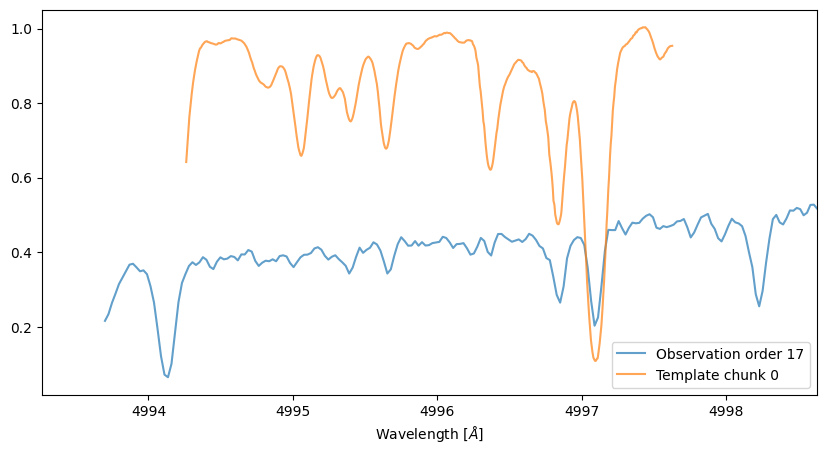

In [9]:
# Overplot template chunk to check
plot_chunk = 0
plot_order = first_order + order_correction

print('Length of template chunk (oversampled):', len(template_chunks[plot_chunk].flux))

fig = plt.figure(figsize=(10,5))
plt.plot(obs[plot_order].wave * (1-z_obs), 
         obs[plot_order].flux/np.max(obs[plot_order].flux), alpha=0.7)
plt.plot(template_chunks[plot_chunk].wave, template_chunks[plot_chunk].flux, alpha=0.7)
plt.xlim(template_chunks[plot_chunk].wave[0]-1, template_chunks[plot_chunk].wave[-1]+1)
plt.legend(['Observation order {}'.format(plot_order), 
            'Template chunk {}'.format(plot_chunk)])
plt.xlabel(r'Wavelength [$\AA$]')
plt.show()

In [10]:
# Pack the template into a HDF5-file as compatible with StellarTemplate_Chunked object

# This is not really important - but I always put in the time of template creation
date = Time.now()

# Filename and starname ('Arcturus' or 'Sun')
temp_filepath = os.path.join(pyodine_path, 
        'tutorial_data/temp_arcturus_atlas.h5')
starname = 'Arcturus'

with h5py.File(temp_filepath, 'w') as h:
    h.create_dataset('/orig_filename', data=temp_filepath)
    h.create_dataset('/starname', data=starname)
    h.create_dataset('/time_start', data=date.isot)
    h.create_dataset('/velocity_offset', data=arc_velocity)
    # The barycentric velocity of the reference spectrum is 0.
    h.create_dataset('/bary_vel_corr', data=0.)
    h.create_dataset('/osample', data=temp_oversampling)
    h.create_dataset('/orders', data=np.array([c.order for c in template_chunks]))
    h.create_dataset('/pix0', data=np.array([c.pix0 for c in template_chunks]))
    h.create_dataset('/weight', data=np.array([c.weight for c in template_chunks]))
    h.create_dataset('/w0', data=np.array([c.w0 for c in template_chunks]))
    h.create_dataset('/w1', data=np.array([c.w1 for c in template_chunks]))

    for i in range(len(template_chunks)):
        grp = '/chunks/{}/'.format(i)
        h.create_dataset(grp + 'flux', data=template_chunks[i].flux)
        h.create_dataset(grp + 'wave', data=template_chunks[i].wave)
        h.create_dataset(grp + 'pixel', data=template_chunks[i].pixel)

Loading template from file: /Users/samkleiman/pyodine/tutorial_data/temp_arcturus_atlas.h5


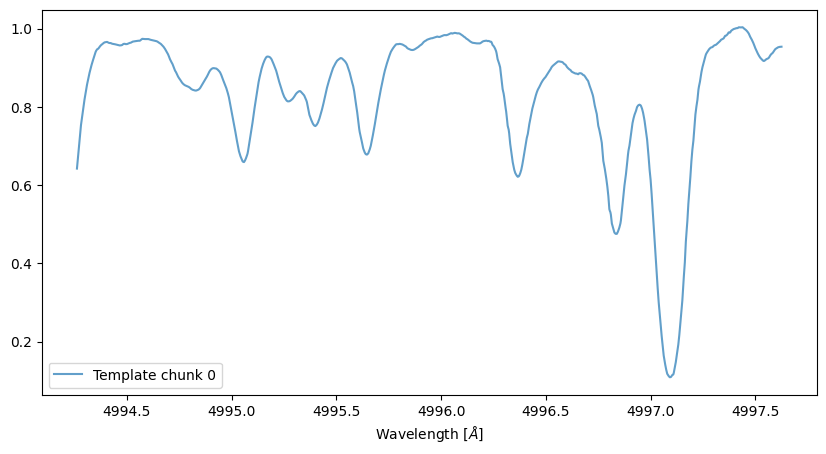

In [11]:
# Test if it can be loaded
arcturus_temp = pyodine.template.base.StellarTemplate_Chunked(temp_filepath)

# Plot template chunk to check
plot_chunk = 0

fig = plt.figure(figsize=(10,5))
plt.plot(arcturus_temp[plot_chunk].wave, arcturus_temp[plot_chunk].flux, alpha=0.7)
plt.legend(['Template chunk {}'.format(plot_chunk)])
plt.xlabel(r'Wavelength [$\AA$]')
plt.show()